In [1]:
import findspark
findspark.init()
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import plotly.express as px
import difflib
import pyspark

In [2]:
spark = SparkSession.builder.getOrCreate() 
dataset_path = 'updated.csv'
df = spark.read.option("header", "true").csv(dataset_path)


In [16]:
df.columns

['months_as_customer',
 'age',
 'policy_number',
 'policy_bind_date',
 'policy_state',
 'policy_csl',
 'policy_deductable',
 'policy_annual_premium',
 'umbrella_limit',
 'insured_zip',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'capital-gains',
 'capital-loss',
 'incident_state',
 'incident_city',
 'incident_location',
 'incident_hour_of_the_day',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'injury_claim',
 'fraud_reported']

In [17]:
# Function to drop columns from DataFrame
def drop_columns(df, columns):
    return df.drop(*columns)

# Prompt the user for columns to drop
drop_columns_input = input("Enter the columns to drop (comma-separated): ")
columns_to_drop = [col.strip() for col in drop_columns_input.split(",")]

# Drop the specified columns
df = drop_columns(df, columns_to_drop)

# Display the updated DataFrame
df.show(10)

+------------------+---+-------------+----------------+------------+----------+-----------------+---------------------+--------------+-----------+-----------+-----------------------+------------------+---------------+--------------------+-------------+------------+--------------+-------------+------------------+------------------------+---------------------------+---------------+--------------+
|months_as_customer|age|policy_number|policy_bind_date|policy_state|policy_csl|policy_deductable|policy_annual_premium|umbrella_limit|insured_zip|insured_sex|insured_education_level|insured_occupation|insured_hobbies|insured_relationship|capital-gains|capital-loss|incident_state|incident_city| incident_location|incident_hour_of_the_day|number_of_vehicles_involved|bodily_injuries|fraud_reported|
+------------------+---+-------------+----------------+------------+----------+-----------------+---------------------+--------------+-----------+-----------+-----------------------+------------------+---

In [13]:
from pyspark.sql.functions import col, when

# Function to fill NaN values in DataFrame using the specified method
def fill_nan_values(df, method):
    # Remove the "property_damage" column from the DataFrame
    df = df.drop("property_damage")
    if method == 'mnar':
        filled_df = df.na.fill('MNAR')
    elif method == 'mar':
        filled_df = df.na.fill('MAR')
    elif method == 'mcar':
        filled_df = df.na.fill('MCAR')
    elif method == 'mean':
        filled_df = df
        for column in filled_df.columns:
            filled_df = filled_df.withColumn(column, col(column).fillna(df.select(column).agg({"column": "mean"}).collect()[0][0]))
    elif method == 'median':
        filled_df = df
        for column in filled_df.columns:
            filled_df = filled_df.withColumn(column, col(column).fillna(df.select(column).agg({"column": "median"}).collect()[0][0]))
    elif method == 'most_frequent':
        filled_df = df
        for column in filled_df.columns:
            if filled_df.schema[column].dataType == 'string':
                mode_value = filled_df.filter(col(column) != '?').groupBy(column).count().orderBy(col("count").desc()).select(column).first()[0]
                filled_df = filled_df.withColumn(column, when(col(column) == '?', mode_value).otherwise(col(column)))
    else:
        print("Invalid method specified!")
        return

    return filled_df

# Prompt the user for the preferred method
method = input("Enter the method to fill NaN values (mnar, mar, mcar, mean, median, most_frequent): ")

# Fill NaN values using the user-specified method
df = fill_nan_values(df, method)

df.show(10)


+------------------+---+-------------+----------------+------------+----------+-----------------+---------------------+--------------+-----------+-----------+-----------------------+------------------+---------------+--------------------+-------------+------------+--------------+-------------+------------------+------------------------+---------------------------+---------------+------------+--------------+
|months_as_customer|age|policy_number|policy_bind_date|policy_state|policy_csl|policy_deductable|policy_annual_premium|umbrella_limit|insured_zip|insured_sex|insured_education_level|insured_occupation|insured_hobbies|insured_relationship|capital-gains|capital-loss|incident_state|incident_city| incident_location|incident_hour_of_the_day|number_of_vehicles_involved|bodily_injuries|injury_claim|fraud_reported|
+------------------+---+-------------+----------------+------------+----------+-----------------+---------------------+--------------+-----------+-----------+--------------------

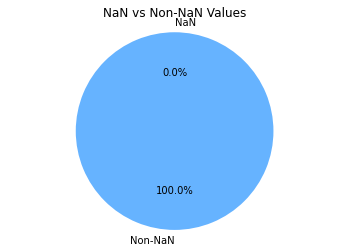

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum as spark_sum

def plot_nan_distribution(df):
    # Calculate the counts of NaN and non-NaN values
    nan_count = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]).groupBy().sum().collect()[0][0]
    non_nan_count = df.count() - nan_count

    # Prepare data for the pie chart
    labels = ['NaN', 'Non-NaN']
    sizes = [nan_count, non_nan_count]
    colors = ['#ff9999', '#66b3ff']

    # Create the pie chart
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('NaN vs Non-NaN Values')

    # Display the pie chart
    plt.show()

# Usage example
plot_nan_distribution(df)


In [18]:
import difflib


def extract_column_names_and_graph_type(text, df):
    tokens = text.split()

    column_names = []
    graph_type = None

    available_columns = df.columns

    for token in tokens:
        if token in available_columns:
            column_names.append(token)
        else:
            matches = difflib.get_close_matches(token, available_columns)
            if len(matches) > 0:
                column_names.append(matches[0])
        if token.lower() in ['bar', 'line', 'scatter', 'histogram']:
            graph_type = token.lower()
    print(column_names,graph_type)
    return column_names, graph_type


def generate_visualization(data, column_names, graph_type):
    
    data = data.toPandas()
    if len(column_names) == 1:
        x_column = column_names[0]
        y_values = [1, 3, 2]  # Placeholder values
    elif len(column_names) == 2:
        x_column = column_names[0]
        y_column = column_names[1]
        y_values = data[y_column]
    else:
        print('Invalid number of column names!')
        return

    if graph_type == 'bar':
        fig = px.bar(data, x=x_column, y=y_values)
    elif graph_type == 'line':
        fig = px.line(data, x=x_column, y=y_values)
    elif graph_type == 'scatter':
        fig = px.scatter(data, x=x_column, y=y_values)
    elif graph_type == 'histogram':
        fig = px.histogram(data, x=x_column)
    else:
        print('Invalid graph type!')
        return

    fig.update_layout(title=f'{graph_type.capitalize()} Plot')
    fig.show()


statement = input("Enter the statement: ")

column_names, graph_type = extract_column_names_and_graph_type(statement, df)

# Generate the requested visualization
if len(column_names) < 1:
    print('Please provide at least two column names.')
elif graph_type is None:
    print('Please specify the type of graph (bar, line, scatter, histogram).')
else:
    generate_visualization(df, column_names, graph_type)

['incident_hour_of_the_day', 'number_of_vehicles_involved'] bar


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed